## Solve for parameters $T$ and $R$

Here the bisection method is used following the notes in slides appendix.

In [1]:
import math

def solve_cycloid_params(
    *,
    x1: float,
    y1: float,
    x2: float,
    y2: float,
    g: float,
    tol=1e-12
) -> tuple[float, float]:
    Δx = x2 - x1
    Δy = y2 - y1
    if Δy == 0:
        raise ValueError("No vertical drop (dy=0): brachistochrone needs Δy ≠ 0.")
    if Δx <= 0:
        raise ValueError("Expect x2 > x1 for left-to-right arc.")

    def f(θ):
        return Δx - Δy * (θ - math.sin(θ)) / (math.cos(θ) - 1.0)

    # Bounds for solution.
    θ_lo, θ_hi = 1e-12, 2*math.pi - 1e-12

    # Bisection
    for _ in range(200):
        θ = 0.5 * (θ_lo + θ_hi)
        if f(θ) > 0:
            θ_lo = θ
        else:
            θ_hi = θ
        if θ_hi - θ_lo < tol:
            break

    θ = 0.5 * (θ_lo + θ_hi)
    R = Δx / (θ - math.sin(θ))
    T = θ * math.sqrt(R / g)

    return R, T

## Configure Brachistochrone Constraints

In [2]:
p1x, p1y = 0.0, 2.5 # initial point
p2x, p2y = 6.0, 0.0 # final point
g = 1.0             # gravitational constant

x_line = 0.0        # initialize first point of line
x_cycl = 0.0        # initialize first point of cycloid
Δt = 0.10           # time step size
max_iters = 100     # max number of time steps

cycl_rad, final_time = solve_cycloid_params(x1=p1x, y1=p1y, x2=p2x, y2=p2y, g=g)

print(f"cycloid radius = {cycl_rad:.5f}")
print(f"final time     = {final_time:.5f}")

cycloid radius = 1.37974
final time     = 4.42236


## Define Forward Euler Step



In [3]:
def dxdt(
    *,
    x: float,
    func: callable,
    grad: callable,
    ε: float = 1.0e-8
) -> float:
    """Evaluate dx/dt using conservation of energy and paramaterization y(x)

    To make forward Euler be well-defined at time t=0, we add ε > 0 as the
    initial energy. We could overcome this by using backward Euler, but
    for sake of illustration, this will be sufficient (since its not
    noticeable with naked eye).
    """
    return (ε - func(x) / (1.0 + grad(x) ** 2.0)) ** 0.5

def forward_euler(
    *,
    x: float,
    func: callable,
    grad: callable,
    x_max: float,
) -> float:
    """Execute a single forward euler step, stopping at endpoint"""
    x_new = x +  Δt * dxdt(x=x, func=func, grad=grad)
    return min(x_max, x_new)


## Curve $y(x)$ and Derivative $y'(x)$

In [4]:
import math

def line(z) -> float:
    return - z * p1y / p2x

def line_grad(z) -> float:
    return - p1y / p2x

def get_theta(*, x: float, R: float) -> float:
    θ_min = 0.0
    θ_max = 6.0
    θ = 0.5 * (θ_min + θ_max)

    while θ_max - θ_min > 1.0e-6:
        θ = 0.5 * (θ_min + θ_max)
        if x < R * (θ - math.sin(θ)):
            θ_max = θ
        else:
            θ_min = θ

    return θ

def cycloid(x: float, R=cycl_rad) -> float:
    """Return y value on cycloid

    Note:
        x = R * (θ - sin(θ))
        y = R * (1 - cos(θ))
    """
    θ = get_theta(x=x, R=R)
    return - R * (1 - math.cos(θ))

def cycloid_grad(x: float, R=cycl_rad) -> float:
    """
        dy/dx = dy/dθ * dθ/dx

        1 = R * (1 - cos(θ)) * dθ/dx

        and so

        dθ/dx = (R * (1 - cos(θ))) ** -1.0
    """
    θ = get_theta(x=x, R=R)
    dydθ = R * math.sin(θ)
    dθdx = (R * (1 - math.cos(θ))) ** -1.0
    return dydθ * dθdx

## Execute Forward Euler for Each Curve

In [5]:
points_line = []
points_cycl = []
for k in range(max_iters):
    x_line = forward_euler(
        x=x_line, func=line, grad=line_grad, x_max=p2x
    )
    x_cycl = forward_euler(
        x=x_cycl, func=cycloid, grad=cycloid_grad, x_max=p2x,
    )

    points_line.append((x_line, p1y + line(x_line)))
    points_cycl.append((x_cycl, p1y + cycloid(x_cycl)))

## Plot Results

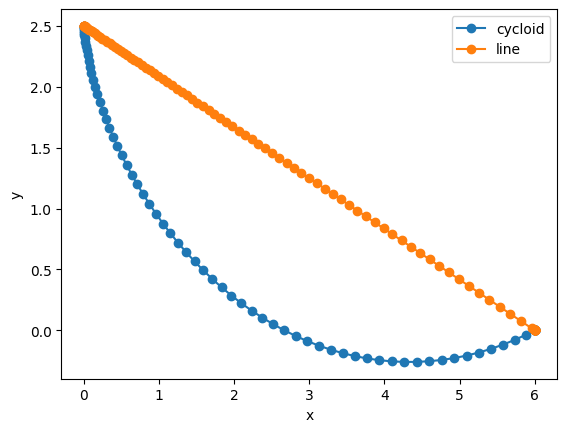

In [6]:
import matplotlib.pyplot as plt

x, y = zip(*points_cycl)
plt.plot(x, y, marker='o', label="cycloid")

x, y = zip(*points_line)
plt.plot(x, y, marker='o', label="line")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Save Results to File

In [7]:
import csv
from pathlib import Path

outfile = Path("brachistochrone_points.csv")
with outfile.open("w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["xc", "yc", "xl", "yl"])   # header
    for p_cycl, p_line in zip(points_cycl, points_line):
        w.writerow([
            f"{p_cycl[0]:.3f}",
            f"{p_cycl[1]:.3f}",
            f"{p_line[0]:.3f}",
            f"{p_line[1]:.3f}"
        ])

outfile = Path("cycloid_params.tex")
with outfile.open("w", encoding="utf-8", newline="\n") as f:
    f.write(f"\\def\\Radius{{{cycl_rad:.6f}}}\n")
    f.write(f"\\def\\Angle{{{final_time:.6f}}}\n")